In [1]:
import pickle

def identity(x):
  return x

vectorizer = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/project/data/vectorizer.pkl', 'rb'))
model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/project/data/model.pkl', 'rb'))

In [2]:
! pip install lemmagen3
! pip install bulstem
! pip install stop-words

import regex as re
from nltk import bigrams

from bulstem.stem import BulStemmer 
from lemmagen3 import Lemmatizer 
from stop_words import get_stop_words

def tokenize(raw_text):
    stop_words = get_stop_words('bulgarian')
    lemmatizer = Lemmatizer('bg')
    stemmer = BulStemmer.from_file('/content/drive/MyDrive/Colab Notebooks/project/data/stem_rules_context_2_utf8.txt',
                                   min_freq=2, left_context=2)

    text = raw_text.lower()  # Make lowercase.
    text = re.sub(u'\\p{P}+', "", text)  # Remove punctuation.
    text = re.sub(u'[a-zA-Z]', "", text)  # Remove non-bulgarian words.

    tokens = text.split()  # Split on whitespace
    tokens = [token for token in tokens if token not in stop_words  # Filter out stopwords
              and all(c.isalpha() for c in token)]  # and non-word tokens.

    # Before lemmatization (sample): ['песни', 'македония', 'българският', 'бог', ..
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization!
    # Before stemming (sample): ['песен', 'македония', 'български', 'бог', ..
    tokens = [stemmer.stem(token) for token in tokens]  # Stemming!

    bi_grams = list(bigrams(tokens))
    tokens += map(lambda x: x[0] + ' ' + x[1], bi_grams)  # Add bi-grams.

    # After pre-processing (sample): ['песен', 'македони', 'българск', 'бог', ..
    return tokens

     |████████████████████████████████| 12.4MB 7.0MB/s 
     |████████████████████████████████| 194kB 54.4MB/s 
     |████████████████████████████████| 839kB 8.2MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32919 sha256=4cf9dac707024306419e4eb08cb75946332020580cc1dcb9cfcd8a2354c56264
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [3]:
# Important constants

NUMBER_OF_SAMPLES = 150 # How many texts to try to predict from all the texts.
PATH_VAZOV = '/content/drive/MyDrive/Colab Notebooks/project/data/vazov_separated/' # Relative or absolute path to a folder containing only texts written from Ivan Vazov.
PATH_JOVKOV = '/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/' # Relative or absolute path to a folder containing only texts written from Jordan jovkov.
BUFFER = 1000 # Minimum length of text to be predicted.
BUFFER_SYMBOL = '@@@@' # A string denoting the start of a new chunk of text in "4_testing_ground_samples.txt"

In [4]:
# get all filenames in one list
from os import listdir
from os.path import isfile, join

vazov_texts = listdir(PATH_VAZOV)
onlyfiles = vazov_texts + listdir(PATH_JOVKOV)

num_texts = len(onlyfiles)
print(f'Total number of texts for Ivan Vazov: {len(vazov_texts)}')
print(f'Total number of texts: {num_texts}')
onlyfiles[:5]

Total number of texts for Ivan Vazov: 17
Total number of texts: 161


['Ivan_Vazov_-_V_lonoto_na_Rila_-_489-b.txt',
 'Ivan_Vazov_-_V_nedrata_na_Rodopite_-_1775-b.txt',
 'Ivan_Vazov_-_Draski_i_sharki_-_493-b.txt',
 'Ivan_Vazov_-_Ljuleka_mi_zamirisa_-_498-b.txt',
 'Ivan_Vazov_-_Ne_shte_zagine_-_500-b.txt']

In [5]:
# Choose random numbers
import random

try:
  testing_texts_idx = random.sample(range(num_texts), NUMBER_OF_SAMPLES)
except ValueError:
  print('Sample size exceeded population size.')
  exit()

samples = [ (PATH_VAZOV + onlyfiles[i], 'Ivan Vazov') if i < len(vazov_texts)
           else (PATH_JOVKOV + onlyfiles[i], 'Jordan Jovkov')
           for i in testing_texts_idx ]

In [6]:
# Create a dataframe from the samples
import pandas as pd

pd.set_option('max_colwidth', 150)

samples_table = pd.DataFrame(samples, columns =['text', 'author'])
samples_table

,text,author
0,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Krystopyt - 7926.txt,Jordan Jovkov
1,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Te pobediha - 7909.txt,Jordan Jovkov
2,/content/drive/MyDrive/Colab Notebooks/project/data/vazov_separated/Ivan_Vazov_-_Epopeja_na_zabravenite_-_3-b.txt,Ivan Vazov
3,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Zvezdna vecher - 7975.txt,Jordan Jovkov
4,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Prizrakyt - 7912.txt,Jordan Jovkov
...,...,...
145,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Bezotechestvenitsi - 7908.txt,Jordan Jovkov
146,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Oblog - 7971.txt,Jordan Jovkov
147,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Sedemte - 7960.txt,Jordan Jovkov
148,/content/drive/MyDrive/Colab Notebooks/project/data/jovkov_separated/Jordan Jovkov - - . Dva vraga - 7878.txt,Jordan Jovkov


In [7]:
# Open every article and choose two random numbers. Make the text column hold those chunks.

to_save = []

def substitute_with_text(filename):
  global to_save

  with open(filename, "r") as f:
    text = f.read()
  
  length = len(text)

  start = random.randrange(length - BUFFER)
  finish = random.randrange(start + BUFFER, length)

  # print(f'Total = {length}\
  # Start = {start}. \
  # Finish = {finish}. \
  # Took = {finish - start} \
  # File = {filename}')

  to_save.append((filename, text[start:finish + 1]))

  return text[start:finish + 1]

samples_table['text'] = samples_table['text'].map(lambda x : substitute_with_text(x))

with open('/content/drive/MyDrive/Colab Notebooks/project/data/4_testing_ground_samples.txt', 'w') as f:
    for name, text in to_save:
      f.write(f'\n{BUFFER_SYMBOL}\n{name}\n{text}\n\n\n')

samples_table

,text,author
0,"ба, случайни пътници и арестанти — цялото това множество непременно ще се отбие в етапния пункт. Там всеки ще намери подслон през нощта, ще почине...",Jordan Jovkov
1,"а сърцето си и шепне:\n\t„Сполай ти, боже. Добър плод ни си дал…“\n\tИ когато една вечер камбаните в глухото малко село тревожно разнасят зловещат...",Jordan Jovkov
2,"стреби над птиче гнездо,\n\tубийците тичат, реват обикалят\n\tплевнята и пушкат, и в прах се повялат\n\tкат кокошки много, що ги лази мор,\n\tи кр...",Ivan Vazov
3,"го слуша Йошка и без да чака отговор от него. Когато той най-подир беше замълчал, Йошка, сега легнал на гърба си и загледан в небето, пак така вне...",Jordan Jovkov
4,"апрегнати топове из тях, вълнуващи се безкрайни колони. Откриваха се тия странни и зловещи декори, между които уверено и твърдо пристъпвашетоя вой...",Jordan Jovkov
...,...,...
145,"ма група хора. Изглежда, че тия, които бяха вече в кафенето, добре ги познават и са ги чакали. Събраха се наедно всички, разговорът стана по-шумен...",Jordan Jovkov
146,"а под ръкавите на бялата й риза. А в сянката на голямата жътварска забрадка се криеше хубаво лице с големи черни очи, пълни с лучи и заградени с т...",Jordan Jovkov
147,"д безстрастно изражение у старите хора, което крие и голяма горест. Беше късно вече и последната надежда изчезваше.\n\t— Хей! Стой там! — извика т...",Jordan Jovkov
148,"лин чувствува страшните му гърчове и затова удвоява силите си и още повече го натиска и бъхти с цялото си тяло. Най-после вълкът, и без това ранен...",Jordan Jovkov


In [8]:
# Predict
import numpy as np

X_test = pd.DataFrame(columns = vectorizer.get_feature_names())
y_test = [] # Used in evalution

for i, text in enumerate(samples_table.text):
  X_test = X_test.append(pd.DataFrame(vectorizer.transform([tokenize(text)]).toarray(), columns = vectorizer.get_feature_names()))
  y_test.append(int(samples_table.author[i] == 'Ivan Vazov'))

y_pred_class = model.predict(X_test) # Used in evalution

## Evaluation

In [9]:
y_test = np.array(y_test)
y_test[:10]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [10]:
y_pred_class = np.array(y_pred_class)
y_pred_class[:10]

array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])

### **Classification accuracy**: percentage of correct predictions

In [11]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.96

Comparing the **actual** and **predicted** response values

In [26]:
# print the first 25 true and predicted responses
print(f'Actual: {y_test[:25]}')
print(f'Pred: {y_pred_class[:25]}')
y_test == y_pred_class

Actual: [0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
Pred: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0.]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

**Conclusion**:

- Classification accuracy is an easy metric but it does not tell the **underlying distribution** of response values.
- The **"types" of errors** made by the classifier are unknown.

### **Confusion matrix**: a table that describes the performance of a classification model

In [13]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[128,   6],
       [  0,  16]])

**Basic terminology**:

- **True Positives (TP)**: *correct* predictions that a text *was* written from Ivan Vazov (bottom right corner)
- **True Negatives (TN)**: *correct* predictions that a text *was not* written from Ivan Vazov (upper left corner)
- **False Positives (FP)**: *incorrect* predictions that a text *was* written from Ivan Vazov (a "Type I error") (upper right)
- **False Negatives (FN)**: *incorrect* predictions that a text *was not* written from Ivan Vazov (a "Type II error") (bottom left)

In [14]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#### **Metrics computed from a confusion matrix**

**Classification Accuracy**: Overall, how often is the classifier correct?

In [15]:
metrics.accuracy_score(y_test, y_pred_class) # (TP + TN) / (TP + TN + FP + FN)

0.96

**Classification Error**: Overall, how often is the classifier incorrect?
 
- Also known as the "Misclassification Rate".

In [16]:
1 - metrics.accuracy_score(y_test, y_pred_class) # (FP + FN) / (TP + TN + FP + FN)

0.040000000000000036

**Sensitivity**: When the actual value is positive, how often is the prediction correct?

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall".

In [17]:
metrics.recall_score(y_test, y_pred_class) # TP / (TP + FN)

1.0

**Specificity**: When the actual value is negative, how often is the prediction correct?

- How "selective" (or "specific") is the classifier to predicting positive instances?

In [18]:
TN / (TN + FP)

0.9552238805970149

**False Positive Rate**: When the actual value is negative, how often is the prediction incorrect?

In [19]:
FP / (TN + FP)

0.04477611940298507

**Precision**: When a positive value is predicted, how often is the prediction correct?

In [20]:
metrics.precision_score(y_test, y_pred_class)

0.7272727272727273

### **Receiver Operating Characteristic Curve (ROC) and Area Under the Curve (AUC)**

**Goal**: See how sensitivity and specificity are affected by various thresholds, without actaully changing the threshold.


Text(0, 0.5, 'Frequency')

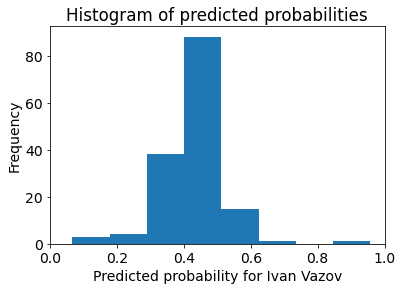

In [21]:
# histogram of predicted probabilities
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

y_pred_proba = model.predict_proba(X_test)[:, 1]

plt.hist(y_pred_proba, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability for Ivan Vazov')
plt.ylabel('Frequency')

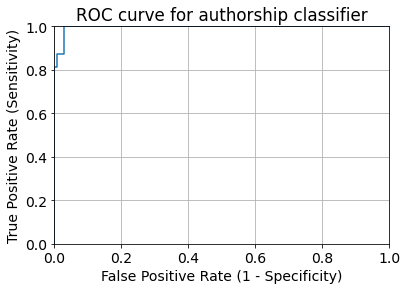

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for authorship classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

The more the ROC curve "hugs" the upper left corner of the plot, the better the classifier as it has high specifity and sensitivity.

AUC is the **percentage** of the ROC plot that is **underneath the curve**

In [23]:
metrics.roc_auc_score(y_test, y_pred_proba)

0.9958022388059702

# Custom Testing

In [25]:
# One very tricky input
# Ivan_Vazov_-_Pystyr_svjat_-_507-b
text = '''Князът беше минал тука, за да се освежи с една-две чаши шампанско. Той беше твърде оживен и весел. Високата му фигура величаво стърчеше между лъскавите униформи там. Когато зърна Гороломова, той се намръщи с отвращение и бързо пошушна на адютанта си:
Qui me l’a fait entrer cette canaille là?
Но в него се възмути аристократът, а не господарят: той се пресили прочее, придоби любезен вид и се ръкува крепко с Гороломова.
Гороломов свали шапката и произнесе разпалена реч, която се зафана с думите, на мода тогава: „Анибал е пред портите“… (по подражание на Френската революция) и се завърши със следващото обръщение към княза, пародия от рефрена на _Шуми Марица_.
 
Марш, марш! Цариград е наш!
 
Княз Александър, който не беше глупав, се усмихна под мустак. Може би затова, че по фатална нужда, вместо да тикне българската граница до Цариград, щеше да приближи турската до Пловдив.
 
 
Нощта беше звездна и тиха. Улиците съвсем пусти. Тържествуващите пияни тълпи бяха се прибрали. Сегиз-тогиз изскачаха на талази весели отдалечени звукове от балната музика. Гороломов се изгуби из тъмните улици. Най-после почука на една вратня.
Това беше III полицейски участък, който пловдивчани никога няма да забравят.
— Пазите ли го? — попита той някаква тъмна фигура, която му отговори.
— В затвора е.
— А ония „предатели“?
— Докарахме ги.
То бяха някои членове от редакцията, която му бе отфърлила романа.
Гороломов влезе в единия затвор. Фенерчето осветли мъжделиво фигурата на един човек, вързан до стълпа. Той беше опълченецът Неделков.
Гороломов неволно потръпна, като че изгуби кураж пред лицето на своя страшен обвинител. Той действително се боеше от опълченеца. Откак бе дошъл в Пловдив, той постоянно излазяше придружен с няколко члена от „Марково коляно“ въоръжени. При всичкото му растящо значение и сила, Гороломову не даваше мир тоя отмъстителен образ и смущаваше тържеството му. Днес заповяда на полицията да арестува Неделков под какъвто ще предлог.
Кога видя и позна Гороломова, гой не удържа гнева си:
— Защо идеш тука, проклети сине!
Гороломов почти изтрезня. Той се спря на почтително разстояние и каза:
— Неделков, дай да се опростим и да забравим всичко.
— С тебе ли? За това ли ме доведе и върза тука?
Грубият глас на Неделков трепереше.
— Смисли, байно, какво приказваш. Ти знаеш кой е Гороломов. Един Гороломов ти иска пардон, не приемаш ли? — И той пристъпи към него.
— Махни се да те не гледам!
— Виж, аз ще те освободя тозчас само под едно условие: ето, дай ми на подпис тука, че нямаш никакво оплакване против мене по въпроса за Марийка, аз бих я зел, но революцията, видиш, ми свързва ръцете… Аз не принадлежа на себе си вече… А сега да се цалуваме братски.
В ответ Неделков го заплю.
Той се отри мълчешком и изскокна навън.
Там се изпречиха четворица души с начернени със сажди лица и с дълги дрехи като попски. Те държаха големи сопи.
— Какво? Призна ли се предателят? — попитаха ниско якобинците.
— Не, продължава да ругае негово височество…
— А за рублите?
— Той се опита и мене да подкупи с тях, за да го освободя… Хай, влезте — заповяда Гороломов; — после пък идете при _ония_…
После прибави по-ниско:
— И повече в гърдите, чувате ли?…
Кога дойде до вратнята, той се ослуша. Скоро се раздаде някакъв глух човешки рев… Гороломов тогава тръгна към дома си. На улицата беше черна нощ, но до слуха му пристигнаха екове от „Марково коляно“:
 
Ний летим на Румелия
помощ да дадем…
 
Преди да си легне, той надраска и изпрати следващата депеша до някои европейски вестници:
„Днес князът прие твърде любезно народната депутация, предводима от знаменития революционер Гороломова. Размениха се политически тостове между двамата. Възхищение всеобщо. Спокойствие пълно.“ Депешите на Гороломова се приемаха безплатно от телеграфа.
Сутринта рано, по зори, когато градът още спеше, една кола изкарваше из III полицейски участък към гробищата едно кърваво тяло; то още дъхаше. Той беше опълченецът Неделков.
Гороломов си отдъхна свободно.
 
 
Сръбската война се обяви. Война безумна и проклета!
Но тя беше един гръмоотвод за Румелия, като я избави от турска — сиреч от ново разорение, и частно за Пловдив, като отвлече легиона.
Той трябваше поне от кумова срама да покаже вид, че е храбър не само против безоръжни и мирни граждани. Той се пръсна. Едни се присъединиха към разни части на войската като канцеларски писари, други съставиха доброволческа дружина, която с голям алай остави Пловдив и се изпари, доде иде до Сливница; а най-многото минаха и останаха в София, в качеството на политици и новинари. Гороломов се записа доброволец в кавалерията с неколцина бивши другари-гимназисти, между които и Спасов — учител вече. Летящият отряд, в който бяха те, се намираше в сръбските предели къде Тимок нейде. Той имаше назначение да безпокои Лешанина и да отвлече част от силите му. Но сериозна среща с неприятеля не бе имал още.
Гороломов, произведен вече офицерин в награда на политически заслуги, роптаеше против съдбата:
— Решително, ние сме нещастни. Войната се свърши почти, а ние ще бъдем принудени да се върнем позорно у дома си, без да сме разменили поне един куршум със сърбите. Аз особено, който щях да си сломя врата да тичам от Цюрих… Война ли е това? Скандал!
— Скандалът се състои не в това, Гороломов — отговори Спасов, като се уравни с коня на приятеля си, — а в самата война между два братски народа. Ето аз кое жалея.
Гороломов го погледна надменно-презрително.
— Тия евангелски разсъждения миришат малко на страшец — забеляза той усмихнато.
— Никак не страх; аз скърбя за безполезните кръвопролития като човек, но като патриот аз съм готов да изпълня длъжността си и да забраня отечеството си. Ако сърбите се оттеглиха доброволно от земята ни, аз бих се радвал, че не са ми дали случай да изпразня един патрон, но ако ги срещна, ще ги бия като врагове.
— Фразички са това… Кажи си правичката: не ми се мре, па да се разберем — каза Гороломов.
Спасов се докачи:
— Ако да беше това вярно, аз не бих вървял с тебе, Гороломов. После, и аз мога да кажа, че и твоята войнственост е…
— Не се докачай де… делата ще покажат… а моята природа, батенка Спасов, е друга… аз казвам à la guerre comme à la guerre… Който тръгва на бой, а мисли за мир, той не е солдатин. Аз искам да видя кръвчица. Песента на куршумите е за мене по-сладка от музиката на Бетховена…
Надвечер малкият отряд пристигна до подножието на едно скалисто бърдо. Мястото беше пусто и диво. Никакви признаци от близък неприятел нямаше.
— Това война ли е? Разходка, скандал! — бъбреше високо Гороломов, за да го чуят другите.
Началникът на отряда обяви, че ще пренощуват в тоя дол, в запустелия хан. Разседлаха конете, вързаха ги, поставиха стражата и се събраха под сушината да почиват.
Гороломов имаше вид на отчаян човек: тая жажда за борба и опасност вдъхваше неволно уважение у другарите му и ги ободряваше.
Изведнаж началникът, който бе обикалял наоколо, на препусканица дойде и обяви, че приел от някои селяни сведения, какво един малък сръбски отряд пешаци влезнал в ближното село да нощува, оттатък бърдото.
— Момчета — продължи той, — ето един случай да опитате сърцата си… Ще починем тук до полунощ, па ще потеглим към селото.
После даде нужните разпореждания и пак бодна коня си нататък.
Конниците се развълнуваха и оживиха. Гороломов ходеше бледен и не знаеше какво става около му. Известието за една близка битка силно смути душата му. Той подири началника и го достигна.
— Що има, Гороломов? — попита го фамилиарно офицерът, човек енергичен, но благоволящ към Гороломова.
— Господин Радинов, сериозно ли сте решили да атакувате?
— Не чу ли, гълъбче? Разпореди ли се?
— Но има явна опасност за отряда.
Капитанът го погледна безпокойно…
— Господин Радинов, отрядът се състои повече от гимназисти, и то доброволци… Аз мисля, че не трябва да ги излагаме.
— Какво ми пееш, Гороломов?
— Те не са обикновени солдати.
— А простите солдати с две души ли са?
— Но това е интелигенцията на България!
— Толкоз по-добре. Интелигенцията ще се бие с повече ентусиазъм. Аз мисля, че и затова сме дошле тук.
— Но интелигенцията… — подзе Гороломов по-упорито.
— Поручик Гороломов! Тук се не разсъждава, а се слуша… — пресече го офицеринът… — Интелигенция, интелигенция!… Па то е въпрос още дали сте вие интелигенцията на България. В редовете на войската има хиляди още интелигентни, като включим и стотина офицери с високо образование. Те отиват в огъня и не се оплакват. Срамота!
— Радинов, мисли каква тежка отговорност земаш!… — каза Гороломов със заплашителен тон.
Началникът съвсем изгуби търпение.
— Поручик Гороломов! Заповядвам ти да изпълниш длъжността си или ще заповядам да те разстрелят, ако деморализираш момчетата! — извика офицеринът и отмина.
Гороломов остана като треснат.
 
 
След полунощ отрядът потегли тихо в тъмнината. Той измина дола, зави на'''

'Jordan Jovkov' if model.predict(vectorizer.transform([tokenize(text)]))[0] == 0 else 'Ivan Vazov'

'Ivan Vazov'